In [1]:
# install flair and other libraries inside jupyter notebook with the correct environment
# note that we are using flair version 0.10
import sys
!{sys.executable} -m pip install flair==0.10 -q

In [2]:
# import other libiaries
import json
import numpy as np
import pickle
import flair
import json
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import Counter
print('current version of flair:', flair.__version__)
from flair.models import SequenceTagger
from flair.data import Sentence,Label

current version of flair: 0.10


In [3]:
# define some functions to calculate label distributions in the dataset
def count_ner_labels(sentences):
    all_labels = []
    count_nolabel_sents = 0
    for sent in sentences:
        sent_labels = []
        for token in sent:
            label = token.get_tag('ner').value
            sent_labels.append(label[2:])
        if (set(sent_labels) == set([''])):
            count_nolabel_sents += 1
            sent_labels = []
        all_labels += sent_labels
        
    n = round(count_nolabel_sents / len(sentences),3) * 100
    print(f'{n}% of the sentences has no label in the training set')
    
    return all_labels

def plot_label_dist(sentences):
    # check label distribution of labaled data by the teacher model
    all_labels = count_ner_labels(sentences)
    label_counts = Counter(all_labels)
    value = label_counts.pop('')
    label_counts.update({'O': value})
    
    perc = np.array(list(label_counts.values())) / sum(label_counts.values()) * 100
    print('For sentences with identified entities, the label distribution are as illustrated as follows:')
    print({k:str(round(n,2))+'%' for k,n in zip(label_counts.keys(),perc)})

    fig, ax = plt.subplots()
    total = sum(label_counts.values())
    ax.bar(label_counts.keys(),height= label_counts.values())
    for i, v in enumerate(label_counts.values()):
        ax.text(i, v+1, f"{v/total*100:.1f}%", ha='center')    
    ax.set_ylabel('number of label counts (token level)')
    ax.set_yscale("log")

## Load unlabled data

the data is obtainable at https://www.kaggle.com/datasets/hadasu92/cnn-articles-after-basic-cleaning 

In [4]:
import pandas as pd
cnn_news = pd.read_csv('CNN_Articels_clean.csv',skiprows=[5464]) # skip one corrupt row 
cnn_news.head()

,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


Number of sentences: 13634


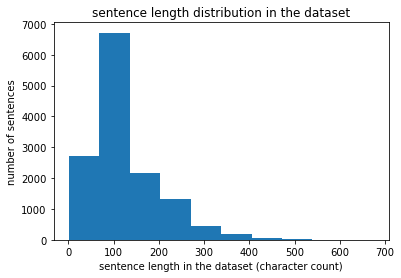

In [6]:
sentences_nolabel  = list(cnn_news.loc[:,'Description']) + list(cnn_news.loc[:,'Headline']) + list(cnn_news.loc[:,'Second headline'])

# optional: randomly remove some short sentences, the hash value depends on each individual sentences, and thus provides reproducibility.
random_numbers = [hash(s) % 100 for s in sentences_nolabel]
sentences_nolabel = [s for s, r in zip(sentences_nolabel, random_numbers) if len(s) >= 70 or r < 50]
print('Number of sentences:',len(sentences_nolabel))

_ = plt.hist([len(s) for s in sentences_nolabel])
_ = plt.title('sentence length distribution in the dataset')
_ = plt.xlabel('sentence length in the dataset (character count)'); _ = plt.ylabel('number of sentences')

In [7]:
# optional: shuffle the filtered sentences
random.seed(123)
random.shuffle(sentences_nolabel)
print(len(sentences_nolabel))
print(sentences_nolabel[0])

13634
Opinion: Surging food prices are hurting those who can least afford it. This is what needs to happen - CNN


In [21]:
# optional: write the selected sentences as json file for easier data loading for potential future use
with open('sentences.json','w') as f:
    json.dump(sentences_nolabel, f)

with open('sentences.json','r') as f:
    sentences_nolabel = json.load(f)

In [8]:
# load teacher model to tag the dataset
teacher = SequenceTagger.load("flair/ner-english-large")

/home/research/.pyenv/versions/miniconda3-4.7.12/envs/qi-py38/lib/python3.8/site-packages/huggingface_hub/file_download.py:588: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-03-15 20:24:07,997 loading file /home/research/.flair/models/ner-english-large/07301f59bb8cb113803be316267f06ddf9243cdbba92a4c8067ef92442d2c574.554244d3476d97501a766a98078421817b14654496b86f2f7bd139dc502a4f29


In [9]:
# export the tag dictionary of the teacher model, to use it later on the student model
dictionary = teacher.tag_dictionary
print(dictionary)
with open('ner_english_large_dictionary.pickle', 'wb') as handle:
    pickle.dump(dictionary, handle, protocol=pickle.HIGHEST_PROTOCOL)

Dictionary with 20 tags: <unk>, O, S-ORG, S-MISC, B-PER, E-PER, S-LOC, B-ORG, E-ORG, I-PER, S-PER, B-MISC, I-MISC, E-MISC, I-ORG, B-LOC, E-LOC, I-LOC, <START>, <STOP>


In [10]:
# tag raw news data with the teacher model
sentences_wlabel_13k = []
for sentence in tqdm(sentences_nolabel):
    sent = Sentence(sentence)
    teacher.predict(sent)
    sentences_wlabel_13k.append(sent)

100%|██████████| 13634/13634 [03:27<00:00, 65.69it/s]


8.3% of the sentences has no label in the training set
For sentences with identified entities, the label distribution are as illustrated as follows:
{'ORG': '3.95%', 'MISC': '3.84%', 'PER': '5.22%', 'LOC': '3.34%', 'O': '83.65%'}


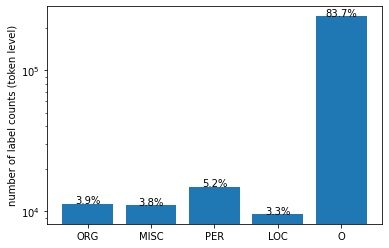

In [35]:
# check label distribution of labaled data by the teacher model
plot_label_dist(sentences_wlabel_13k)

## Load CONLL_03 (English)

CONLL_03 is a labeled dataset for named entity recognition

The data can be found here https://www.clips.uantwerpen.be/conll2003/ner/ 

or download directly from kaggle: https://www.kaggle.com/datasets/henavajov/conll2003



In [12]:
from flair.datasets import CONLL_03
corpus = CONLL_03(base_path='./',encoding= 'latin-1' )
print(corpus)
corpus.train[3]

2023-03-15 20:29:34,526 Reading data from conll_03
2023-03-15 20:29:34,526 Train: conll_03/eng.train
2023-03-15 20:29:34,526 Dev: conll_03/eng.dev
2023-03-15 20:29:34,527 Test: conll_03/eng.test
Corpus: 14987 train + 3466 dev + 3684 test sentences


Sentence: "BRUSSELS 1996-08-22"   [− Tokens: 2  − Token-Labels: "BRUSSELS <NNP/B-NP/S-LOC> 1996-08-22 <CD/I-NP>"]

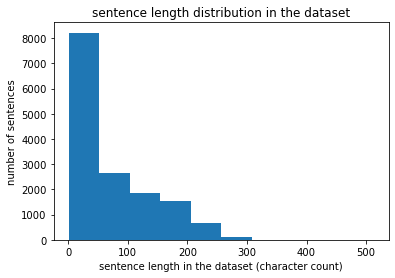

In [13]:
# check sentence length in the dataset
_ = plt.hist([len(s.to_original_text()) for s in corpus.train])
_ = plt.title('sentence length distribution in the dataset')
_ = plt.xlabel('sentence length in the dataset (character count)'); _ = plt.ylabel('number of sentences')

25.7% of the sentences has no label in the training set
For sentences with identified entities, the label distribution are as illustrated as follows:
{'ORG': '5.84%', 'MISC': '2.67%', 'PER': '6.48%', 'LOC': '4.83%', 'O': '80.18%'}


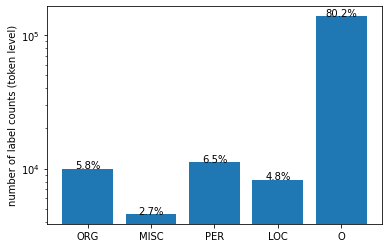

In [36]:
plot_label_dist(corpus.train)

In [15]:
# tag the training set of conll dataset with teacher model
# note: since the teacher model is already very good at ner prediction, the difference is minimal here compared to the graph above
train_conll = []
for sentence in tqdm(corpus.train):
    sent = Sentence(sentence.to_original_text())
    teacher.predict(sent)
    train_conll.append(sent)

100%|██████████| 14987/14987 [03:31<00:00, 70.71it/s]


26.200000000000003% of the sentences has no label in the training set
For sentences with identified entities, the label distribution are as illustrated as follows:
{'ORG': '5.97%', 'MISC': '2.55%', 'PER': '6.44%', 'LOC': '4.64%', 'O': '80.4%'}


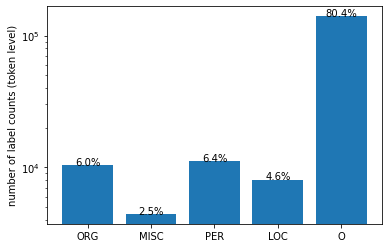

In [37]:
plot_label_dist(train_conll)

## Export pre-processed dataset

In [17]:
# combine conll training data with the labeled data by the teacher model
random.seed(123)
train_28k = sentences_wlabel_13k + train_conll
random.shuffle(train_28k)

In [18]:
with open('pre_processed_data/en_train_mixed_28k.pickle', 'wb') as handle:
    pickle.dump(train_28k, handle, protocol=pickle.HIGHEST_PROTOCOL)